(7043, 21)
X_scaled.shape 	= (7043, 20)
X_umap.shape 	= (7043, 4)


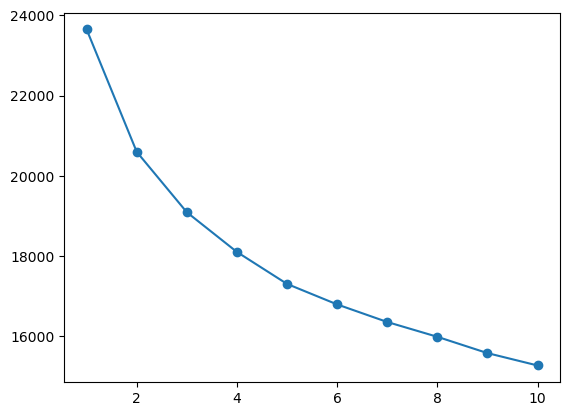

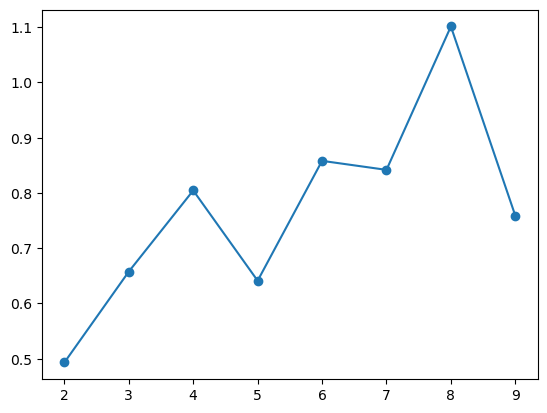

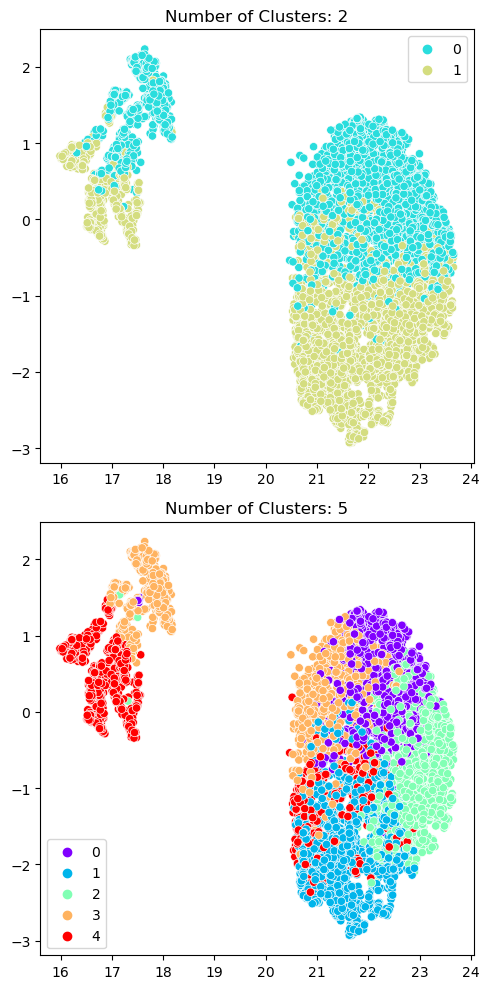

In [16]:
# !pip install umap-learn

import umap
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Manual settings:

target = 'Churn' # Если у нас есть target 
#(чтобы исключить target колонку, а классифицировать без учителя с применением K-means), 
#иначе ставим 
#target = ''

n_components = 4 # Default 2
n_neighbors = 200 # Default 15
min_dist = 0.1 # Default 0.1

n_results = 2 # Сколько хороших вариантов разбиения на кластеры показать

isMinMaxScaler = True # True - MinMaxScaler, False - StandardScaler

#

def find_and_sort_minimums(D):
    optimal_ones = {}
    lst = [1e8,] + D + [1e8,]
    for i in range(1, len(lst) - 1):
        if lst[i-1] > lst[i] < lst[i+1]:
            optimal_ones[lst[i]] = i + 1
    return list(map(lambda i: optimal_ones[i], sorted(optimal_ones)))
    

reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist) #, random_state=1) ← "Use no seed for parallelism"

df = pd.read_csv(r'.\0.Dataset\WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(df.shape)

# Automatic LabelEncode all non numerical features:

categorical_cols = df.select_dtypes(['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])
#print(df.head())

# Normalization

if target != '':
    X = df.drop(target, axis=1)

if isMinMaxScaler:
    X_scaled = MinMaxScaler().fit_transform(X)
else:
    X_scaled = StandardScaler().fit_transform(X)

# Processing with reduce dimensions

X_umap = reducer.fit_transform(X_scaled)
print('X_scaled.shape \t=', X_scaled.shape)
print('X_umap.shape \t=', X_umap.shape)

# Add clustering colors

# Find optimal number of clusters — метод "Каменистой осыпи" (еще называют "Метод локтя")
inertia = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=10, n_init=10).fit(X_scaled)
    labels = kmeans.labels_
    inertia_i = kmeans.inertia_
    inertia.append(inertia_i)

plt.plot(range(1,11), inertia, marker='o');
plt.show()

D = []
for i in range(1,9):
    Di = (inertia[i] - inertia[i+1])/(inertia[i-1] - inertia[i])
    D.append(Di)

#n_clusters = D.index(min(D)) + 2
optimal_ones = find_and_sort_minimums(D)[:n_results]

plt.plot(range(2,10), D, marker='o');
plt.show()

# Create a figure with as many subplots as there are optimal ones
fig, axs = plt.subplots(len(optimal_ones), 1, figsize=(5, len(optimal_ones)*5))
for i, n_clusters in enumerate(optimal_ones):
     # Calculate clusters

    kmeans = KMeans(n_clusters=n_clusters, random_state=10, n_init=10).fit(X_scaled)
    labels = kmeans.labels_

    # Plot results

    sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=labels, palette='rainbow', ax=axs[i]);
    axs[i].set_title('Number of Clusters: ' + str(n_clusters))

    if i == len(optimal_ones) - 1:
        # Save the figure to a PNG file
        fig.get_figure().savefig('UMAPplusKmeans_clusters.png', 
                                 dpi=120, bbox_inches='tight', pad_inches = 0.5)
plt.tight_layout()
plt.show()